In [1]:
# imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

In [2]:
import torch

if torch.cuda.is_available():
    device = "cuda"
    print("✅ GPU detected:", torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("💡 Running on CPU (no GPU found)")


✅ GPU detected: NVIDIA GeForce RTX 2060


In [3]:
# _-------------_ new

def load_and_preprocess_data_optimized(file_path="cicids2017_cleaned.csv", chunk_size=200000):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import RandomOverSampler
    from sklearn.model_selection import train_test_split

    print("🚀 Loading CICIDS2017 dataset in optimized mode...")

    # Step 1: Load in chunks to avoid memory blowup
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
        # Downcast numeric columns
        for col in chunk.select_dtypes(include=['float64']).columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')
        for col in chunk.select_dtypes(include=['int64']).columns:
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        chunks.append(chunk)
        print(f"📦 Loaded {len(chunks)*chunk_size:,} rows...")

    df = pd.concat(chunks, ignore_index=True)
    print(f"✅ Dataset fully loaded! Shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

    # Cleaning
    df.columns = df.columns.str.strip()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    label_col = "Attack Type"
    X = df.drop(label_col, axis=1)
    y_str = df[label_col]

    # Known/unknown split (same as before)
    unknown_attack_labels = ['Port Scanning', 'Bot']
    all_attacks = y_str[y_str != 'Normal Traffic'].unique()
    known_attack_labels = [atk for atk in all_attacks if atk not in unknown_attack_labels]
    df_known = df[df[label_col].isin(known_attack_labels)]
    df_unknown = df[df[label_col].isin(unknown_attack_labels)]
    df_benign = df[df[label_col].isin(['BENIGN', 'Normal Traffic'])]

    X_train_benign, X_test_benign, y_train_benign, y_test_benign = train_test_split(
        df_benign.drop(label_col, axis=1), df_benign[label_col], train_size=0.8, random_state=42
    )

    if not df_known.empty:
        X_train_known, X_test_known, y_train_known, y_test_known = train_test_split(
            df_known.drop(label_col, axis=1), df_known[label_col],
            train_size=0.8, random_state=42, stratify=df_known[label_col]
        )
    else:
        X_train_known, X_test_known, y_train_known, y_test_known = (
            pd.DataFrame(), pd.DataFrame(), pd.Series(dtype=str), pd.Series(dtype=str)
        )

    X_train_unbalanced = pd.concat([X_train_benign, X_train_known])
    y_train_unbalanced_str = pd.concat([y_train_benign, y_train_known])
    y_train_unbalanced = y_train_unbalanced_str.apply(lambda x: 0 if x in ['BENIGN', 'Normal Traffic'] else 1)

    X_test_overall = pd.concat([X_test_benign, X_test_known, df_unknown.drop(label_col, axis=1)])
    y_test_overall_str = pd.concat([y_test_benign, y_test_known, df_unknown[label_col]])
    y_test_overall = y_test_overall_str.apply(lambda x: 0 if x in ['BENIGN', 'Normal Traffic'] else 1)

    benign_for_unknown_test = X_test_benign.sample(n=len(df_unknown), random_state=42) if not df_unknown.empty else X_test_benign
    X_test_unknown = pd.concat([benign_for_unknown_test, df_unknown.drop(label_col, axis=1)])
    y_test_unknown = pd.Series([0] * len(benign_for_unknown_test) + [1] * len(df_unknown))

    # Scaling + oversampling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_unbalanced.astype(np.float32))
    X_test_overall_scaled = scaler.transform(X_test_overall.astype(np.float32))
    X_test_unknown_scaled = scaler.transform(X_test_unknown.astype(np.float32))

    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train_unbalanced)

    print("✅ Preprocessing complete.")
    return X_train_resampled, y_train_resampled, X_train_scaled, y_train_unbalanced, X_test_overall_scaled, y_test_overall, X_test_unknown_scaled, y_test_unknown, df


In [4]:
(X_train_resampled, y_train_resampled,
 X_train_unbalanced, y_train_unbalanced,
 X_test_overall, y_test_overall,
 X_test_unknown, y_test_unknown, df) = load_and_preprocess_data_optimized("data\cicids2017_cleaned.csv")


🚀 Loading CICIDS2017 dataset in optimized mode...
📦 Loaded 200,000 rows...
📦 Loaded 400,000 rows...
📦 Loaded 600,000 rows...
📦 Loaded 800,000 rows...
📦 Loaded 1,000,000 rows...
📦 Loaded 1,200,000 rows...
📦 Loaded 1,400,000 rows...
📦 Loaded 1,600,000 rows...
📦 Loaded 1,800,000 rows...
📦 Loaded 2,000,000 rows...
📦 Loaded 2,200,000 rows...
📦 Loaded 2,400,000 rows...
📦 Loaded 2,600,000 rows...
✅ Dataset fully loaded! Shape: (2520751, 53)
💾 Memory usage: 751.46 MB
✅ Preprocessing complete.


In [5]:
df.head

<bound method NDFrame.head of          Destination Port  Flow Duration  Total Fwd Packets  \
0                      22        1266342                 41   
1                      22        1319353                 41   
2                      22            160                  1   
3                      22        1303488                 41   
4                   35396             77                  1   
...                   ...            ...                ...   
2520746                53          32215                  4   
2520747                53            324                  2   
2520748             58030             82                  2   
2520749                53        1048635                  6   
2520750                53          94939                  4   

         Total Length of Fwd Packets  Fwd Packet Length Max  \
0                               2664                    456   
1                               2664                    456   
2                       

In [6]:
df['Attack Type'].unique()

array(['Normal Traffic', 'Port Scanning', 'Web Attacks', 'Brute Force',
       'DDoS', 'Bots', 'DoS'], dtype=object)

In [7]:
df['Attack Type'].value_counts()


Attack Type
Normal Traffic    2094890
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2520584 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int32  
 1   Flow Duration                int32  
 2   Total Fwd Packets            int32  
 3   Total Length of Fwd Packets  int32  
 4   Fwd Packet Length Max        int16  
 5   Fwd Packet Length Min        int16  
 6   Fwd Packet Length Mean       float32
 7   Fwd Packet Length Std        float32
 8   Bwd Packet Length Max        int16  
 9   Bwd Packet Length Min        int16  
 10  Bwd Packet Length Mean       float32
 11  Bwd Packet Length Std        float32
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int32  
 17  Flow IAT Min                 int32  
 18  Fwd IAT Total                int32  
 19  Fwd I

In [9]:
# Check unique labels in all splits
import numpy as np

print("🔍 Checking label classes after preprocessing:\n")

print("y_train_resampled unique values:", np.unique(y_train_resampled))
print("y_train_resampled count:", len(np.unique(y_train_resampled)))

print("\ny_test_overall unique values:", np.unique(y_test_overall))
print("y_test_overall count:", len(np.unique(y_test_overall)))

print("\ny_test_unknown unique values:", np.unique(y_test_unknown))
print("y_test_unknown count:", len(np.unique(y_test_unknown)))


🔍 Checking label classes after preprocessing:

y_train_resampled unique values: [0 1]
y_train_resampled count: 2

y_test_overall unique values: [0 1]
y_test_overall count: 2

y_test_unknown unique values: [0 1]
y_test_unknown count: 2


In [10]:
# Models
def build_mlp(input_shape):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=(input_shape, 1), return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_autoencoder(input_shape):
    input_layer = Input(shape=(input_shape,))
    encoder = Dense(128, activation="relu")(input_layer)
    encoder = Dense(64, activation="relu")(encoder)
    encoder = Dense(32, activation="relu")(encoder)
    decoder = Dense(64, activation="relu")(encoder)
    decoder = Dense(128, activation="relu")(decoder)
    decoder = Dense(input_shape, activation="sigmoid")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# MLP
# -------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# -------------------------------
# LSTM
# -------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 64, batch_first=True, num_layers=1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        out = self.dropout(torch.relu(self.fc1(out)))
        out = self.sigmoid(self.fc2(out))
        return out

# -------------------------------
# Autoencoder
# -------------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


Using device: cuda


In [12]:
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import numpy as np
import pandas as pd

# -----------------------------
# Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# Helper: PyTorch training
# -----------------------------
def train_pytorch_model(model, X_train, y_train=None, epochs=10, batch_size=512, is_autoencoder=False):
    model = model.to(device)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    if not is_autoencoder:
        y_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32).to(device)

    dataset = TensorDataset(X_train) if is_autoencoder else TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss() if is_autoencoder else nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            if is_autoencoder:
                X_batch = batch[0]
                output = model(X_batch)
                loss = criterion(output, X_batch)
            else:
                X_batch, y_batch = batch
                output = model(X_batch)
                loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        tqdm.write(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(loader):.6f}")
    return model


# -----------------------------
# Helper: Evaluation with tqdm
# -----------------------------
def evaluate_model_tqdm(name, model, X_test, y_test, is_dl=False, is_autoencoder=False, ae_threshold=None):
    if is_dl:
        model.eval()

    y_pred = np.zeros(len(y_test))
    batch_size = 512
    num_batches = (len(X_test) + batch_size - 1) // batch_size

    start_time = time.time()
    for i in tqdm(range(num_batches), desc=f"Evaluating {name}", unit="batch", leave=False):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(X_test))
        X_batch = X_test[start_idx:end_idx]

        if is_dl:
            X_tensor = torch.tensor(X_batch, dtype=torch.float32).to(device)
            with torch.no_grad():
                outputs = model(X_tensor)
                if is_autoencoder:
                    errors = torch.mean((X_tensor - outputs) ** 2, dim=1).cpu().numpy()
                    y_pred[start_idx:end_idx] = (errors > ae_threshold).astype(int)
                else:
                    preds = outputs.cpu().numpy()
                    preds = (preds > 0.5).astype(int).flatten()
                    y_pred[start_idx:end_idx] = preds
        else:
            y_pred[start_idx:end_idx] = model.predict(X_batch)

    elapsed = time.time() - start_time
    print(f"\n{name} Evaluation Time: {elapsed:.2f} sec")

    y_pred = np.clip(y_pred, 0, 1).astype(int)

    print(f"{name} Results:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=['Benign', 'Attack']))
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0)
    }

    return metrics, y_pred  # <-- return predictions too


# -----------------------------
# Model Builders
# -----------------------------
def build_mlp(input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )
    return model


def build_lstm(input_dim, hidden_dim=64, num_layers=1):
    class LSTMModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = x.unsqueeze(1)
            _, (h_n, _) = self.lstm(x)
            out = self.fc(h_n[-1])
            return self.sigmoid(out)
    return LSTMModel()


def build_autoencoder(input_dim):
    model = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )
    return model


# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    models = [
        ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), False, False),
        ("XGBoost", XGBClassifier(random_state=42, eval_metric='logloss', tree_method='gpu_hist', predictor='gpu_predictor'), False, False),
        ("LightGBM", LGBMClassifier(random_state=42, device='gpu'), False, False),
        ("MLP", build_mlp(X_train_resampled.shape[1]), True, False),
        ("LSTM", build_lstm(X_train_resampled.shape[1]), True, False),
        ("Isolation Forest", IsolationForest(random_state=42, n_jobs=-1), False, True),
        ("Autoencoder", build_autoencoder(X_train_resampled.shape[1]), True, True)
    ]

    all_results = {}
    predictions_data = {
        "True_Label_Overall": y_test_overall.values,
        "True_Label_Unknown": y_test_unknown.values
    }

    for name, model, is_dl, is_unsupervised in tqdm(models, desc="Overall Models", unit="model"):
        print(f"\n====================\nProcessing Model: {name}\n====================")

        train_X = X_train_unbalanced if is_unsupervised else X_train_resampled
        train_y = y_train_unbalanced if is_unsupervised else y_train_resampled

        ae_threshold = None
        if is_dl:
            is_ae = name == "Autoencoder"
            trained_model = train_pytorch_model(model, train_X, train_y, epochs=10, is_autoencoder=is_ae)

            if is_ae:
                X_train_benign = train_X[train_y == 0]
                trained_model.eval()
                with torch.no_grad():
                    X_tensor = torch.tensor(X_train_benign, dtype=torch.float32).to(device)
                    outputs = trained_model(X_tensor)
                    errors = torch.mean((X_tensor - outputs) ** 2, dim=1).cpu().numpy()
                    ae_threshold = np.percentile(errors, 95)
        else:
            trained_model = model.fit(train_X, train_y)

        # Evaluate and collect predictions
        results = {}

        overall_metrics, overall_preds = evaluate_model_tqdm(
            name, trained_model, X_test_overall, y_test_overall,
            is_dl=is_dl, is_autoencoder=name == "Autoencoder", ae_threshold=ae_threshold
        )
        results["Overall"] = overall_metrics
        predictions_data[f"{name} (Overall)"] = overall_preds

        unknown_metrics, unknown_preds = evaluate_model_tqdm(
            name, trained_model, X_test_unknown, y_test_unknown,
            is_dl=is_dl, is_autoencoder=name == "Autoencoder", ae_threshold=ae_threshold
        )
        results["Unknown Attack"] = unknown_metrics
        predictions_data[f"{name} (Unknown)"] = unknown_preds

        all_results[name] = results
        del model, trained_model
        gc.collect()

    # -----------------------------
    # ✅ Save predictions correctly
    # -----------------------------
    overall_data = {k: v for k, v in predictions_data.items() if "(Unknown)" not in k and "Unknown" not in k}
    unknown_data = {k: v for k, v in predictions_data.items() if "Unknown" in k}

    pd.DataFrame(overall_data).to_csv("model_predictions_overall.csv", index=False)
    pd.DataFrame(unknown_data).to_csv("model_predictions_unknown.csv", index=False)

    print("\n✅ Saved predictions to:")
    print(" - model_predictions_overall.csv")
    print(" - model_predictions_unknown.csv")

    # -----------------------------
    # ✅ Save model comparison summary
    # -----------------------------
    comparison_rows = []
    for name, results in all_results.items():
        for test_name, metrics in results.items():
            row = {"Model": name, "Test Set": test_name, **metrics}
            comparison_rows.append(row)

    comparison_df = pd.DataFrame(comparison_rows)
    comparison_df.to_csv("model_comparison_summary.csv", index=False)
    print("\n✅ Saved model performance summary to 'model_comparison_summary.csv'")

    # -----------------------------
    # Print final table
    # -----------------------------
    print("\n\n=== FINAL COMPARISON TABLE ===")
    print("-" * 110)
    print(f"{'Model':<22} | {'Test Set':<20} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
    print("-" * 110)
    for name, results in all_results.items():
        for test_name, metrics in results.items():
            print(f"{name:<22} | {test_name:<20} | {metrics['Accuracy']:.4f} | {metrics['Precision']:.4f} | {metrics['Recall']:.4f} | {metrics['F1-Score']:.4f}")
    print("-" * 110)


Using device: cuda


Overall Models:   0%|          | 0/7 [00:00<?, ?model/s]


Processing Model: Random Forest



Random Forest Evaluation Time: 30.05 sec
Random Forest Results:
              precision    recall  f1-score   support

      Benign       0.82      1.00      0.90    418978
      Attack       1.00      0.42      0.60    157694

    accuracy                           0.84    576672
   macro avg       0.91      0.71      0.75    576672
weighted avg       0.87      0.84      0.82    576672




Random Forest Evaluation Time: 9.90 sec
Random Forest Results:
              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67     90694
      Attack       0.74      0.00      0.00     90694

    accuracy                           0.50    181388
   macro avg       0.62      0.50      0.34    181388
weighted avg       0.62      0.50      0.34    181388



Overall Models:  14%|█▍        | 1/7 [05:03<30:18, 303.07s/model]


Processing Model: XGBoost



XGBoost Evaluation Time: 4.54 sec
XGBoost Results:
              precision    recall  f1-score   support

      Benign       0.82      1.00      0.90    418978
      Attack       1.00      0.43      0.60    157694

    accuracy                           0.84    576672
   macro avg       0.91      0.71      0.75    576672
weighted avg       0.87      0.84      0.82    576672




XGBoost Evaluation Time: 1.69 sec
XGBoost Results:
              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67     90694
      Attack       0.87      0.01      0.01     90694

    accuracy                           0.50    181388
   macro avg       0.68      0.50      0.34    181388
weighted avg       0.68      0.50      0.34    181388



Overall Models:  29%|██▊       | 2/7 [05:15<11:01, 132.38s/model]


Processing Model: LightGBM
[LightGBM] [Info] Number of positive: 1675912, number of negative: 1675912
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11948
[LightGBM] [Info] Number of data points in the train set: 3351824, number of used features: 52
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (166.22 MB) transferred to GPU in 0.118583 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000



LightGBM Evaluation Time: 1.50 sec
LightGBM Results:
              precision    recall  f1-score   support

      Benign       0.82      1.00      0.90    418978
      Attack       1.00      0.43      0.60    157694

    accuracy                           0.84    576672
   macro avg       0.91      0.71      0.75    576672
weighted avg       0.87      0.84      0.82    576672




LightGBM Evaluation Time: 0.47 sec
LightGBM Results:
              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67     90694
      Attack       0.84      0.01      0.01     90694

    accuracy                           0.50    181388
   macro avg       0.67      0.50      0.34    181388
weighted avg       0.67      0.50      0.34    181388



Overall Models:  43%|████▎     | 3/7 [05:31<05:15, 78.95s/model] 


Processing Model: MLP


Overall Models:  43%|████▎     | 3/7 [06:06<05:15, 78.95s/model]

Epoch 1/10 Loss: 0.061534


Overall Models:  43%|████▎     | 3/7 [06:40<05:15, 78.95s/model]

Epoch 2/10 Loss: 0.039866


Overall Models:  43%|████▎     | 3/7 [07:14<05:15, 78.95s/model]

Epoch 3/10 Loss: 0.037039


Overall Models:  43%|████▎     | 3/7 [07:48<05:15, 78.95s/model]

Epoch 4/10 Loss: 0.037515


Overall Models:  43%|████▎     | 3/7 [08:22<05:15, 78.95s/model]

Epoch 5/10 Loss: 0.036754


Overall Models:  43%|████▎     | 3/7 [08:56<05:15, 78.95s/model]

Epoch 6/10 Loss: 0.035330


Overall Models:  43%|████▎     | 3/7 [09:30<05:15, 78.95s/model]

Epoch 7/10 Loss: 0.036456


Overall Models:  43%|████▎     | 3/7 [10:05<05:15, 78.95s/model]

Epoch 8/10 Loss: 0.034692


Overall Models:  43%|████▎     | 3/7 [10:39<05:15, 78.95s/model]

Epoch 9/10 Loss: 0.034773


Overall Models:  43%|████▎     | 3/7 [11:13<05:15, 78.95s/model]

Epoch 10/10 Loss: 0.034561



MLP Evaluation Time: 0.53 sec
MLP Results:
              precision    recall  f1-score   support

      Benign       0.82      0.99      0.90    418978
      Attack       0.94      0.42      0.59    157694

    accuracy                           0.84    576672
   macro avg       0.88      0.71      0.74    576672
weighted avg       0.85      0.84      0.81    576672




MLP Evaluation Time: 0.16 sec
MLP Results:
              precision    recall  f1-score   support

      Benign       0.50      0.99      0.66     90694
      Attack       0.15      0.00      0.00     90694

    accuracy                           0.50    181388
   macro avg       0.33      0.50      0.33    181388
weighted avg       0.33      0.50      0.33    181388



Overall Models:  57%|█████▋    | 4/7 [11:14<09:10, 183.39s/model]


Processing Model: LSTM


Overall Models:  57%|█████▋    | 4/7 [11:50<09:10, 183.39s/model]

Epoch 1/10 Loss: 0.068208


Overall Models:  57%|█████▋    | 4/7 [12:25<09:10, 183.39s/model]

Epoch 2/10 Loss: 0.034560


Overall Models:  57%|█████▋    | 4/7 [13:01<09:10, 183.39s/model]

Epoch 3/10 Loss: 0.028326


Overall Models:  57%|█████▋    | 4/7 [13:35<09:10, 183.39s/model]

Epoch 4/10 Loss: 0.024981


Overall Models:  57%|█████▋    | 4/7 [14:11<09:10, 183.39s/model]

Epoch 5/10 Loss: 0.022747


Overall Models:  57%|█████▋    | 4/7 [14:46<09:10, 183.39s/model]

Epoch 6/10 Loss: 0.021327


Overall Models:  57%|█████▋    | 4/7 [15:21<09:10, 183.39s/model]

Epoch 7/10 Loss: 0.020177


Overall Models:  57%|█████▋    | 4/7 [15:56<09:10, 183.39s/model]

Epoch 8/10 Loss: 0.019323


Overall Models:  57%|█████▋    | 4/7 [16:31<09:10, 183.39s/model]

Epoch 9/10 Loss: 0.018588


Overall Models:  57%|█████▋    | 4/7 [17:06<09:10, 183.39s/model]

Epoch 10/10 Loss: 0.017910



LSTM Evaluation Time: 0.96 sec
LSTM Results:
              precision    recall  f1-score   support

      Benign       0.82      0.99      0.90    418978
      Attack       0.95      0.42      0.59    157694

    accuracy                           0.84    576672
   macro avg       0.89      0.71      0.74    576672
weighted avg       0.86      0.84      0.81    576672




LSTM Evaluation Time: 0.26 sec
LSTM Results:
              precision    recall  f1-score   support

      Benign       0.50      0.99      0.66     90694
      Attack       0.17      0.00      0.00     90694

    accuracy                           0.50    181388
   macro avg       0.33      0.50      0.33    181388
weighted avg       0.33      0.50      0.33    181388



Overall Models:  71%|███████▏  | 5/7 [17:08<08:09, 244.89s/model]


Processing Model: Isolation Forest



Isolation Forest Evaluation Time: 7.09 sec
Isolation Forest Results:
              precision    recall  f1-score   support

      Benign       0.53      0.06      0.11    418978
      Attack       0.25      0.85      0.39    157694

    accuracy                           0.28    576672
   macro avg       0.39      0.46      0.25    576672
weighted avg       0.45      0.28      0.19    576672




Isolation Forest Evaluation Time: 2.18 sec
Isolation Forest Results:
              precision    recall  f1-score   support

      Benign       0.97      0.06      0.12     90694
      Attack       0.52      1.00      0.68     90694

    accuracy                           0.53    181388
   macro avg       0.74      0.53      0.40    181388
weighted avg       0.74      0.53      0.40    181388



Overall Models:  86%|████████▌ | 6/7 [17:19<02:45, 165.30s/model]


Processing Model: Autoencoder


Overall Models:  86%|████████▌ | 6/7 [17:33<02:45, 165.30s/model]

Epoch 1/10 Loss: 0.099550


Overall Models:  86%|████████▌ | 6/7 [17:47<02:45, 165.30s/model]

Epoch 2/10 Loss: 0.070399


Overall Models:  86%|████████▌ | 6/7 [18:01<02:45, 165.30s/model]

Epoch 3/10 Loss: 0.053885


Overall Models:  86%|████████▌ | 6/7 [18:15<02:45, 165.30s/model]

Epoch 4/10 Loss: 0.049412


Overall Models:  86%|████████▌ | 6/7 [18:29<02:45, 165.30s/model]

Epoch 5/10 Loss: 0.054136


Overall Models:  86%|████████▌ | 6/7 [18:43<02:45, 165.30s/model]

Epoch 6/10 Loss: 0.047969


Overall Models:  86%|████████▌ | 6/7 [18:58<02:45, 165.30s/model]

Epoch 7/10 Loss: 0.042678


Overall Models:  86%|████████▌ | 6/7 [19:12<02:45, 165.30s/model]

Epoch 8/10 Loss: 0.039989


Overall Models:  86%|████████▌ | 6/7 [19:26<02:45, 165.30s/model]

Epoch 9/10 Loss: 0.044625


Overall Models:  86%|████████▌ | 6/7 [19:40<02:45, 165.30s/model]

Epoch 10/10 Loss: 0.037591



Autoencoder Evaluation Time: 0.54 sec
Autoencoder Results:
              precision    recall  f1-score   support

      Benign       0.72      0.95      0.82    418978
      Attack       0.24      0.04      0.07    157694

    accuracy                           0.70    576672
   macro avg       0.48      0.50      0.45    576672
weighted avg       0.59      0.70      0.62    576672




Autoencoder Evaluation Time: 0.17 sec
Autoencoder Results:
              precision    recall  f1-score   support

      Benign       0.49      0.95      0.65     90694
      Attack       0.31      0.02      0.04     90694

    accuracy                           0.49    181388
   macro avg       0.40      0.49      0.35    181388
weighted avg       0.40      0.49      0.35    181388



Overall Models: 100%|██████████| 7/7 [19:41<00:00, 168.85s/model]



✅ Saved predictions to:
 - model_predictions_overall.csv
 - model_predictions_unknown.csv

✅ Saved model performance summary to 'model_comparison_summary.csv'


=== FINAL COMPARISON TABLE ===
--------------------------------------------------------------------------------------------------------------
Model                  | Test Set             | Accuracy   | Precision  | Recall     | F1-Score  
--------------------------------------------------------------------------------------------------------------
Random Forest          | Overall              | 0.8423 | 0.9972 | 0.4246 | 0.5957
Random Forest          | Unknown Attack       | 0.5005 | 0.7389 | 0.0017 | 0.0033
XGBoost                | Overall              | 0.8431 | 0.9958 | 0.4281 | 0.5988
XGBoost                | Unknown Attack       | 0.5024 | 0.8651 | 0.0058 | 0.0115
LightGBM               | Overall              | 0.8429 | 0.9951 | 0.4277 | 0.5982
LightGBM               | Unknown Attack       | 0.5021 | 0.8378 | 0.0052 | 0.

In [14]:
print(results)
print(all_results)

{'Overall': {'Accuracy': 0.7014819516120082, 'Precision': 0.24051132895256563, 'Recall': 0.042474666125534265, 'F1-Score': 0.072198897290655}, 'Unknown Attack': {'Accuracy': 0.48605751207356607, 'Precision': 0.30901676483914814, 'Recall': 0.022559375482391338, 'F1-Score': 0.04204901608179623}}
{'Random Forest': {'Overall': {'Accuracy': 0.842345388713168, 'Precision': 0.9972449329103933, 'Recall': 0.4246451989295725, 'F1-Score': 0.5956511877176519}, 'Unknown Attack': {'Accuracy': 0.5005347652545924, 'Precision': 0.7389162561576355, 'Recall': 0.0016539131585330893, 'F1-Score': 0.0033004389583814646}}, 'XGBoost': {'Overall': {'Accuracy': 0.8431170578769214, 'Precision': 0.9958107151286287, 'Recall': 0.428094918005758, 'F1-Score': 0.598777751168587}, 'Unknown Attack': {'Accuracy': 0.5024477914746289, 'Precision': 0.8651315789473685, 'Recall': 0.005799722142589367, 'F1-Score': 0.011522201047074543}}, 'LightGBM': {'Overall': {'Accuracy': 0.8429176377559514, 'Precision': 0.9950720745975773, '

In [16]:
import pandas as pd

# Your results dictionary
all_results_dict = {
    'Random Forest': {'Overall': {'Accuracy': 0.842345388713168, 'Precision': 0.9972449329103933, 'Recall': 0.4246451989295725, 'F1-Score': 0.5956511877176519}, 'Unknown Attack': {'Accuracy': 0.5005347652545924, 'Precision': 0.7389162561576355, 'Recall': 0.0016539131585330893, 'F1-Score': 0.0033004389583814646}},
    'XGBoost': {'Overall': {'Accuracy': 0.8431170578769214, 'Precision': 0.9958107151286287, 'Recall': 0.428094918005758, 'F1-Score': 0.598777751168587}, 'Unknown Attack': {'Accuracy': 0.5024477914746289, 'Precision': 0.8651315789473685, 'Recall': 0.005799722142589367, 'F1-Score': 0.011522201047074543}},
    'LightGBM': {'Overall': {'Accuracy': 0.8429176377559514, 'Precision': 0.9950720745975773, 'Recall': 0.4276827273073167, 'F1-Score': 0.5982410154742739}, 'Unknown Attack': {'Accuracy': 0.5020894436236135, 'Precision': 0.8377896613190731, 'Recall': 0.005182261230070346, 'F1-Score': 0.010300805435318612}},
    'MLP': {'Overall': {'Accuracy': 0.8355651046001886, 'Precision': 0.9432951164135325, 'Recall': 0.4241759356728855, 'F1-Score': 0.5852015485225608}, 'Unknown Attack': {'Accuracy': 0.49592586058614685, 'Precision': 0.1549953314659197, 'Recall': 0.0018303305621099521, 'F1-Score': 0.0036179371219964038}},
    'LSTM': {'Overall': {'Accuracy': 0.8365674074690639, 'Precision': 0.9511497930799095, 'Recall': 0.42412520451000035, 'F1-Score': 0.5866559069518575}, 'Unknown Attack': {'Accuracy': 0.49670319977065736, 'Precision': 0.16777777777777778, 'Recall': 0.0016649392462566432, 'F1-Score': 0.0032971592025678536}},
    'Isolation Forest': {'Overall': {'Accuracy': 0.27808182120859, 'Precision': 0.25388281511709354, 'Recall': 0.8458660443644019, 'F1-Score': 0.3905452607724357}, 'Unknown Attack': {'Accuracy': 0.531192802169934, 'Precision': 0.5161303197555079, 'Recall': 0.9980924868238251, 'F1-Score': 0.680409503980036}},
    'Autoencoder': {'Overall': {'Accuracy': 0.7014819516120082, 'Precision': 0.24051132895256563, 'Recall': 0.042474666125534265, 'F1-Score': 0.072198897290655}, 'Unknown Attack': {'Accuracy': 0.48605751207356607, 'Precision': 0.30901676483914814, 'Recall': 0.022559375482391338, 'F1-Score': 0.04204901608179623}}
}

# Convert nested dict into a DataFrame
rows = []
for model_name, test_sets in all_results_dict.items():
    for test_set_name, metrics in test_sets.items():
        row = {
            "Model": model_name,
            "Test Set": test_set_name,
            "Accuracy": metrics["Accuracy"],
            "Precision": metrics["Precision"],
            "Recall": metrics["Recall"],
            "F1-Score": metrics["F1-Score"]
        }
        rows.append(row)

# Create DataFrame
all_results_df = pd.DataFrame(rows)

# Sort for better readability
all_results_df = all_results_df.sort_values(["Model", "Test Set"]).reset_index(drop=True)

# Round and format nicely
for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    all_results_df[col] = all_results_df[col].astype(float).round(4)

# Print the formatted table
print("\n=== FINAL COMPARISON TABLE ===")
print("------------------------------------------------------------")
print(
    all_results_df.to_string(
        index=False,
        justify="center",
        col_space=12
    )
)
print("------------------------------------------------------------")


print("------------------------------------------------------------")



=== FINAL COMPARISON TABLE ===
------------------------------------------------------------
     Model          Test Set      Accuracy     Precision     Recall      F1-Score  
     Autoencoder        Overall    0.7015       0.2405       0.0425       0.0722   
     Autoencoder Unknown Attack    0.4861       0.3090       0.0226       0.0420   
Isolation Forest        Overall    0.2781       0.2539       0.8459       0.3905   
Isolation Forest Unknown Attack    0.5312       0.5161       0.9981       0.6804   
            LSTM        Overall    0.8366       0.9511       0.4241       0.5867   
            LSTM Unknown Attack    0.4967       0.1678       0.0017       0.0033   
        LightGBM        Overall    0.8429       0.9951       0.4277       0.5982   
        LightGBM Unknown Attack    0.5021       0.8378       0.0052       0.0103   
             MLP        Overall    0.8356       0.9433       0.4242       0.5852   
             MLP Unknown Attack    0.4959       0.1550       0.0018

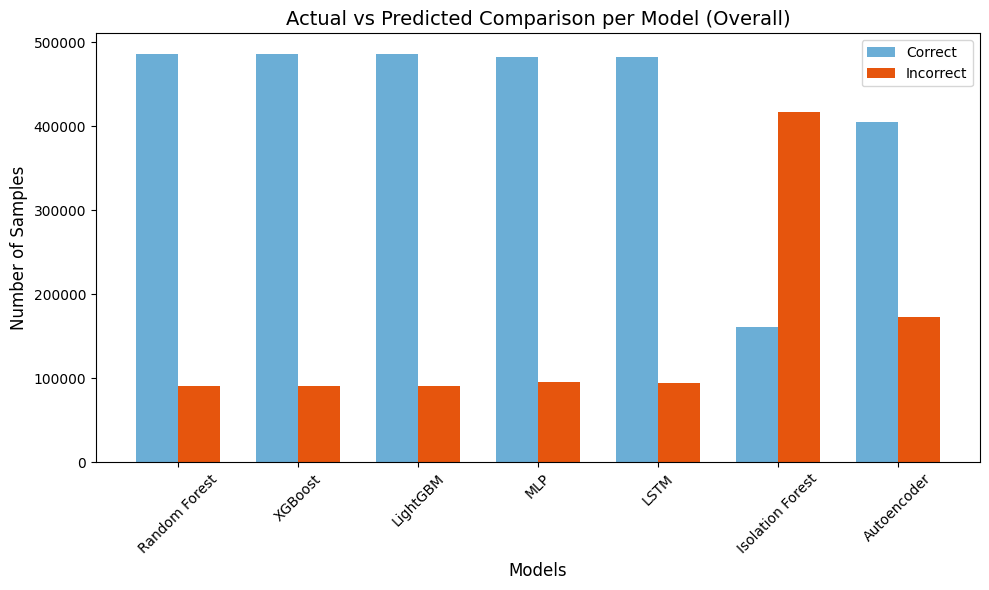

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV (you can switch to the unknown one as needed)
df = pd.read_csv("model_predictions_overall.csv")

# Identify true label column and model prediction columns
true_col = "True_Label_Overall"
model_cols = [col for col in df.columns if col != true_col]

# Calculate correct and incorrect counts
model_results = []
for model_col in model_cols:
    correct = (df[model_col] == df[true_col]).sum()
    incorrect = (df[model_col] != df[true_col]).sum()
    model_name = model_col.replace(" (Overall)", "")
    model_results.append({"Model": model_name, "Correct": correct, "Incorrect": incorrect})

results_df = pd.DataFrame(model_results)

# Plot
plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df))

plt.bar(x, results_df["Correct"], width=bar_width, label="Correct", color='#6baed6')
plt.bar([i + bar_width for i in x], results_df["Incorrect"], width=bar_width, label="Incorrect", color='#e6550d')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Actual vs Predicted Comparison per Model (Overall)", fontsize=14)
plt.xticks([i + bar_width/2 for i in x], results_df["Model"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


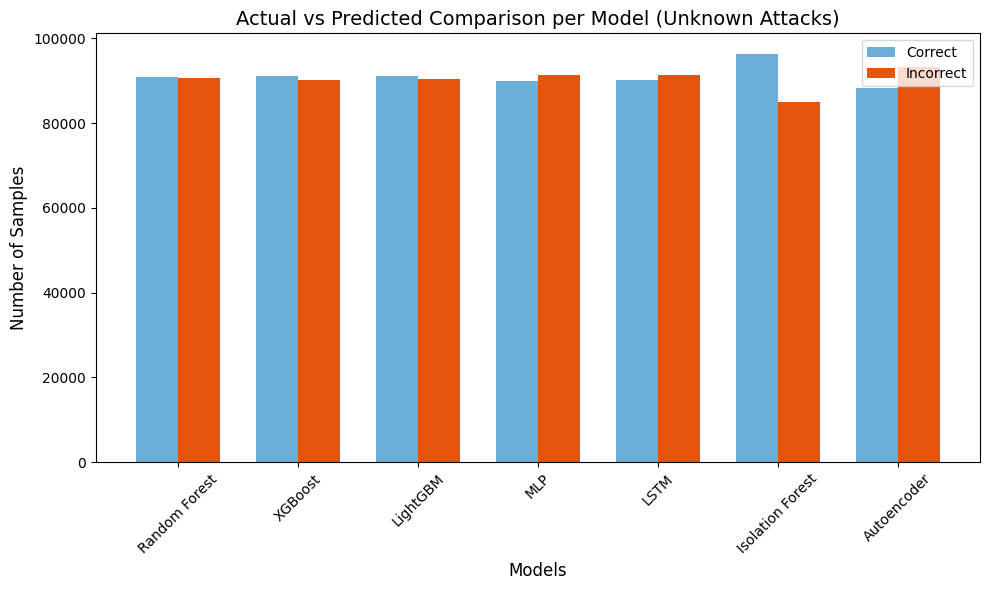

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the second CSV
df_unknown = pd.read_csv("model_predictions_unknown.csv")

# Identify true label and model prediction columns
true_col = "True_Label_Unknown"
model_cols = [col for col in df_unknown.columns if col != true_col]

# Compute correct & incorrect counts for each model
model_results = []
for model_col in model_cols:
    correct = (df_unknown[model_col] == df_unknown[true_col]).sum()
    incorrect = (df_unknown[model_col] != df_unknown[true_col]).sum()
    model_name = model_col.replace(" (Unknown)", "")
    model_results.append({"Model": model_name, "Correct": correct, "Incorrect": incorrect})

results_df = pd.DataFrame(model_results)

# Plot grouped bar chart
plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(results_df))

plt.bar(x, results_df["Correct"], width=bar_width, label="Correct", color='#6baed6')
plt.bar([i + bar_width for i in x], results_df["Incorrect"], width=bar_width, label="Incorrect", color='#e6550d')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Actual vs Predicted Comparison per Model (Unknown Attacks)", fontsize=14)
plt.xticks([i + bar_width/2 for i in x], results_df["Model"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Loading CSVs...

Columns in overall CSV:
['True_Label_Overall', 'Random Forest (Overall)', 'XGBoost (Overall)', 'LightGBM (Overall)', 'MLP (Overall)', 'LSTM (Overall)', 'Isolation Forest (Overall)', 'Autoencoder (Overall)']

Columns in unknown CSV:
['True_Label_Unknown', 'Random Forest (Unknown)', 'XGBoost (Unknown)', 'LightGBM (Unknown)', 'MLP (Unknown)', 'LSTM (Unknown)', 'Isolation Forest (Unknown)', 'Autoencoder (Unknown)']

Loaded metrics CSV with columns:
['Model', 'Test Set', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

Detected overall true column: True_Label_Overall
Detected overall prediction cols: ['Random Forest (Overall)', 'XGBoost (Overall)', 'LightGBM (Overall)', 'MLP (Overall)', 'LSTM (Overall)', 'Isolation Forest (Overall)', 'Autoencoder (Overall)']

Detected unknown true column: True_Label_Unknown
Detected unknown prediction cols: ['Random Forest (Unknown)', 'XGBoost (Unknown)', 'LightGBM (Unknown)', 'MLP (Unknown)', 'LSTM (Unknown)', 'Isolation Forest (Unknown)', 

<Figure size 1200x600 with 0 Axes>

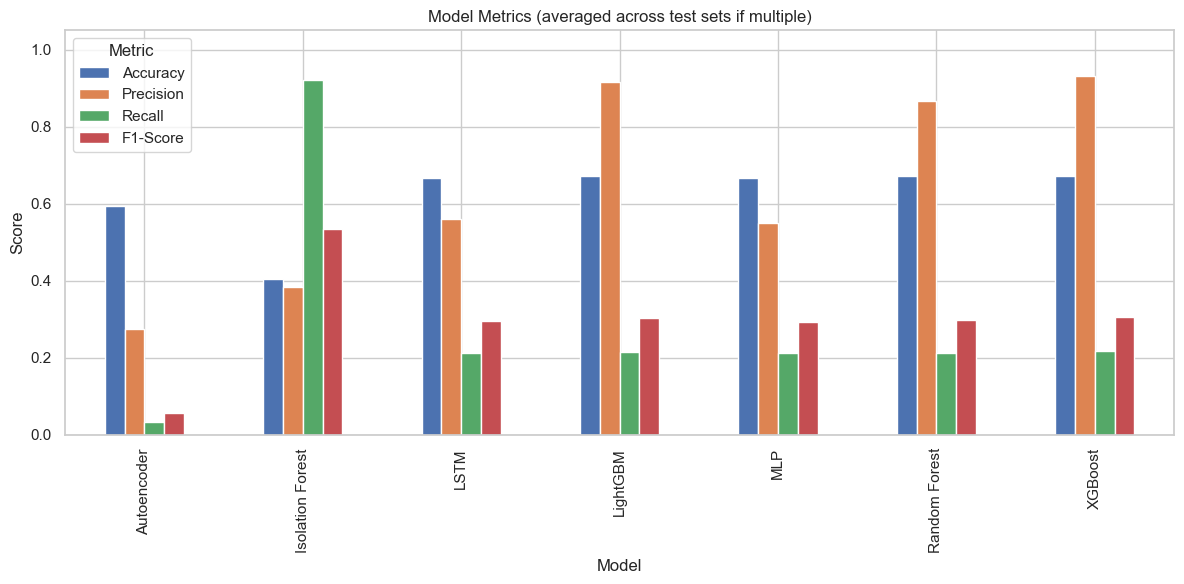


Plotting Actual vs Predicted counts (Overall)...


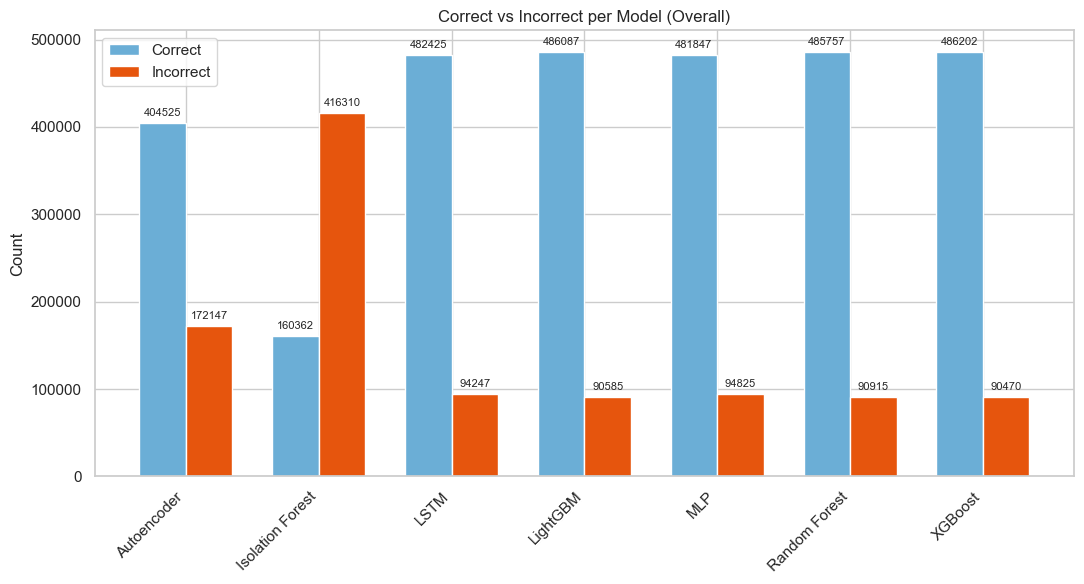


Plotting Actual vs Predicted counts (Unknown)...


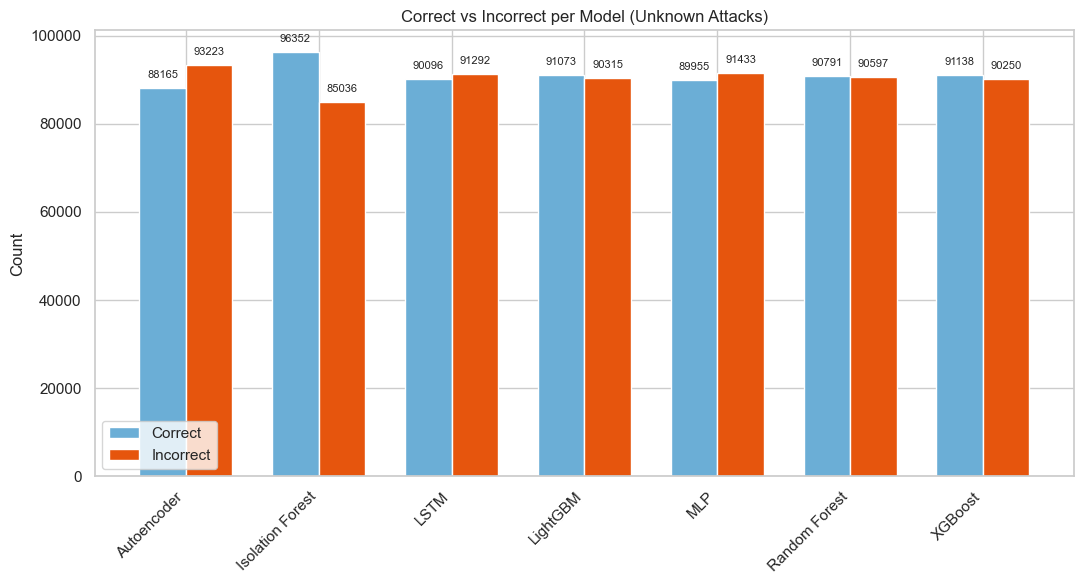


Plotting confusion matrices for Overall...


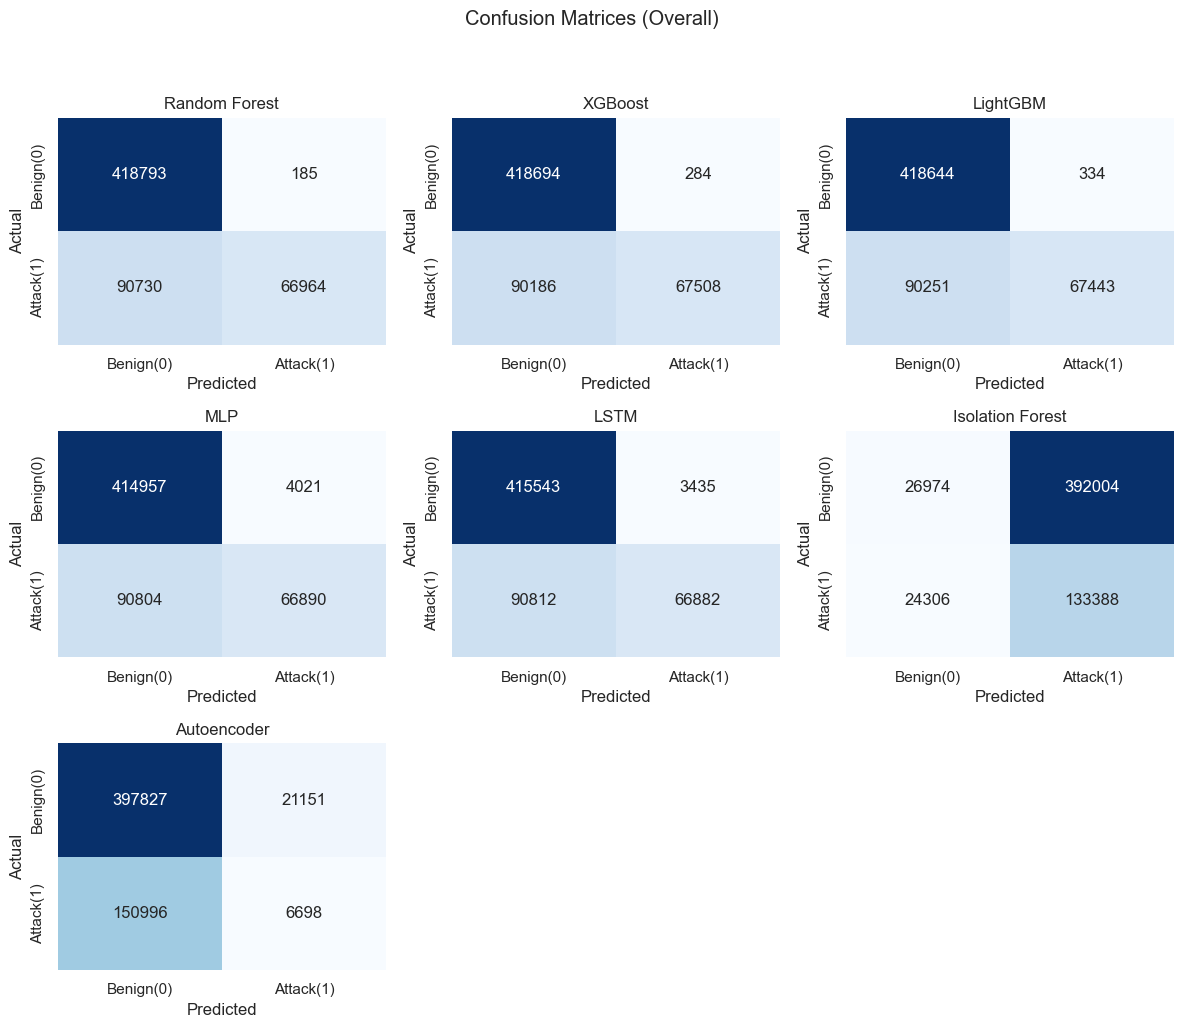


Plotting ROC & PR curves (Overall)...


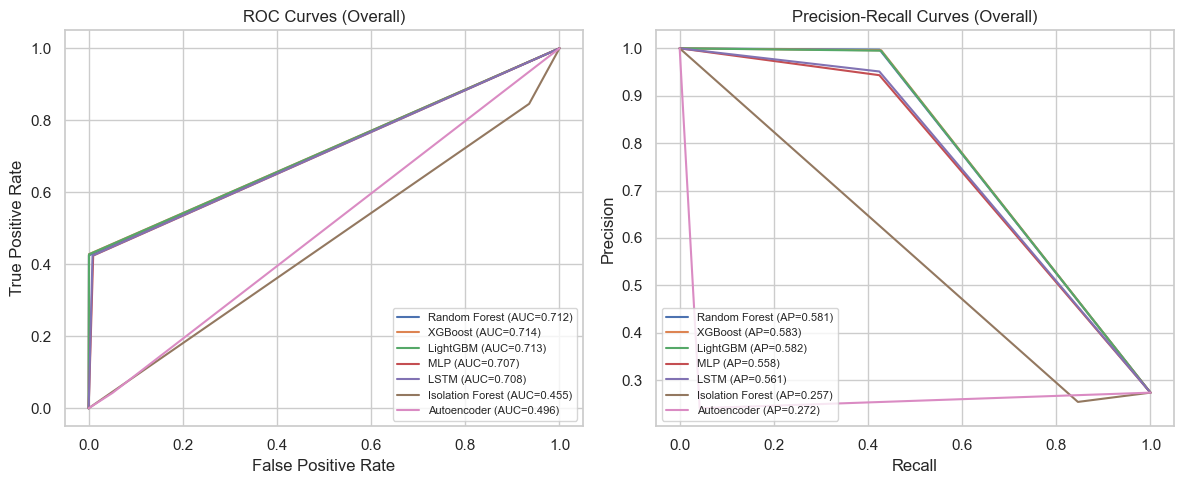

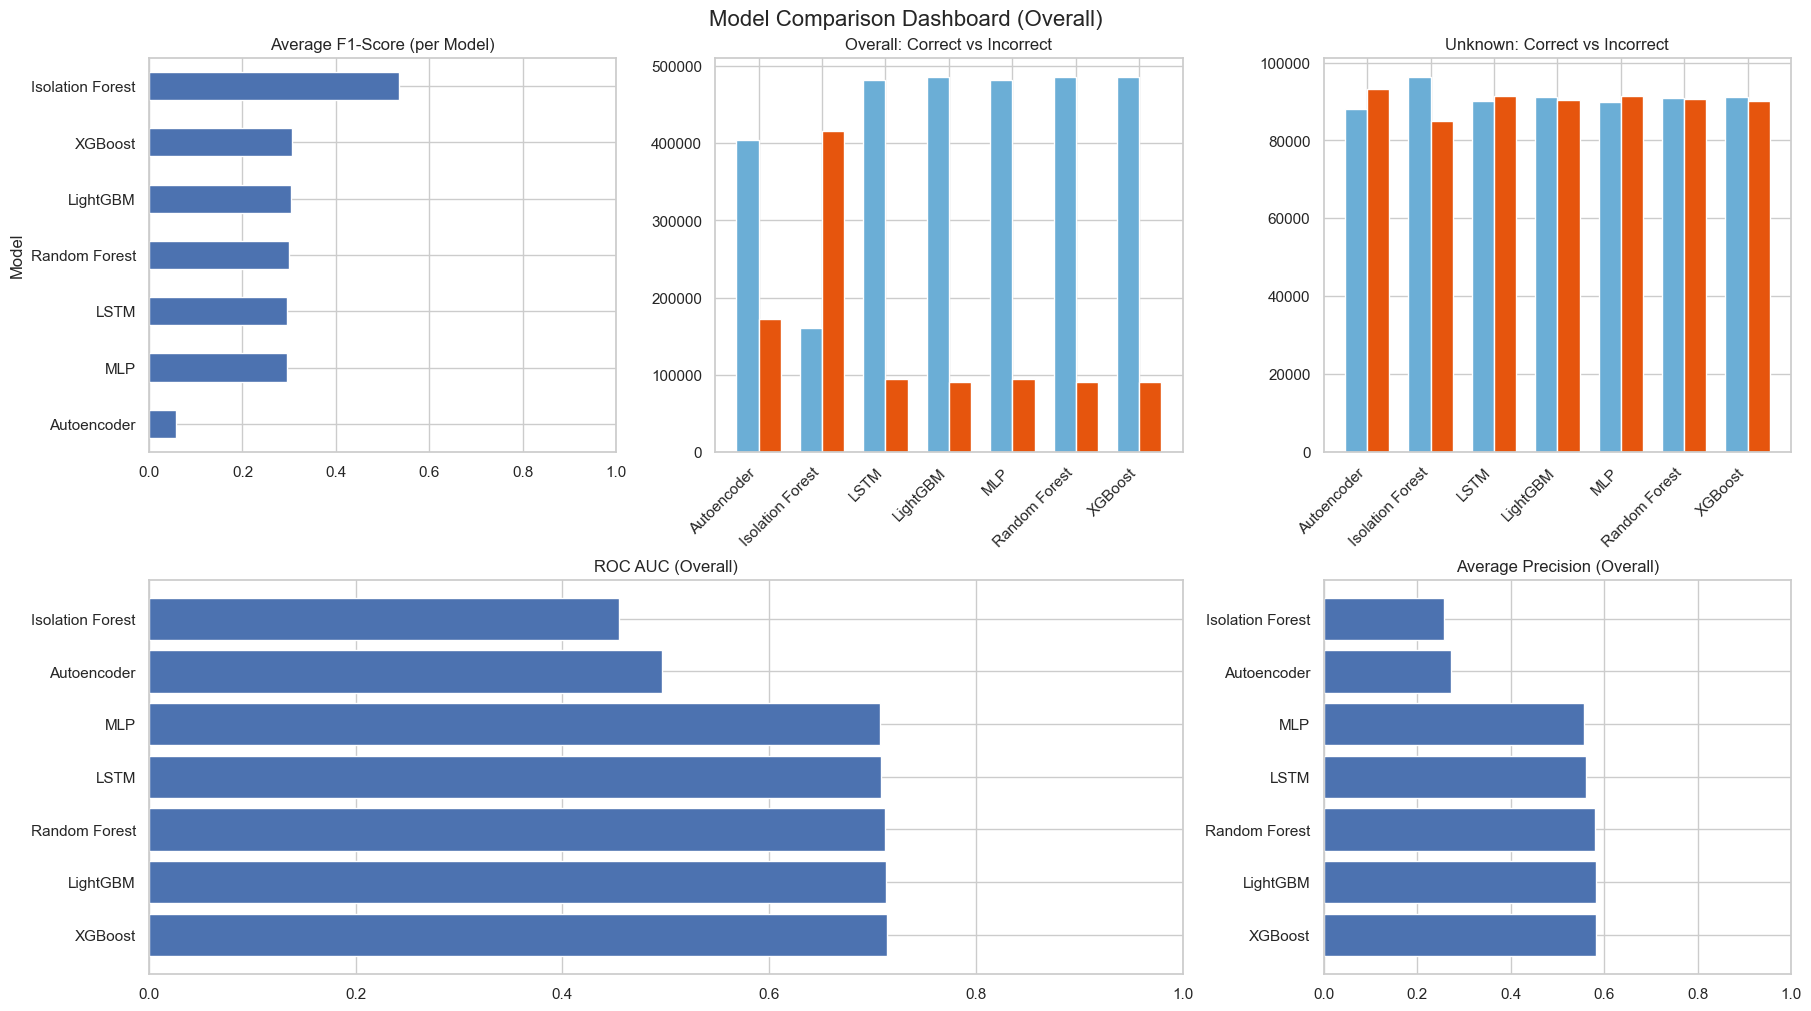


Saved summary CSVs: overall_correct_incorrect_summary.csv, unknown_correct_incorrect_summary.csv


In [11]:
# Plots - Combined script (Matplotlib + Seaborn, light theme)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

sns.set_theme(style="whitegrid")  # light theme

# -------------------------
# Files (adjust paths if needed)
# -------------------------
overall_csv = "model_predictions_overall.csv"
unknown_csv = "model_predictions_unknown.csv"
metrics_csv = "model_comparison_summary.csv"  # optional; script will handle if missing

# -------------------------
# Load CSVs & show columns
# -------------------------
print("Loading CSVs...")
df_overall = pd.read_csv(overall_csv)
df_unknown = pd.read_csv(unknown_csv)
print("\nColumns in overall CSV:")
print(df_overall.columns.tolist())
print("\nColumns in unknown CSV:")
print(df_unknown.columns.tolist())

metrics_df = None
if os.path.exists(metrics_csv):
    metrics_df = pd.read_csv(metrics_csv)
    print("\nLoaded metrics CSV with columns:")
    print(metrics_df.columns.tolist())
else:
    print(f"\nNo '{metrics_csv}' found — metric-plot will be skipped unless you have it.")

# -------------------------
# Helper: detect true/pred columns
# -------------------------
def detect_columns(df, true_candidates):
    # Find which true label column exists
    true_col = None
    for cand in true_candidates:
        if cand in df.columns:
            true_col = cand
            break
    if true_col is None:
        raise ValueError(f"None of expected true-label columns found. Tried: {true_candidates}. Found: {df.columns.tolist()}")
    # All other columns are prediction columns
    pred_cols = [c for c in df.columns if c != true_col]
    return true_col, pred_cols

true_candidates_overall = ["True_Label_Overall", "True_Label", "True", "y_true", "y_true_overall"]
true_candidates_unknown = ["True_Label_Unknown", "True_Label", "True", "y_true", "y_true_unknown"]

true_overall_col, pred_overall_cols = detect_columns(df_overall, true_candidates_overall)
true_unknown_col, pred_unknown_cols = detect_columns(df_unknown, true_candidates_unknown)

print(f"\nDetected overall true column: {true_overall_col}")
print(f"Detected overall prediction cols: {pred_overall_cols}")
print(f"\nDetected unknown true column: {true_unknown_col}")
print(f"Detected unknown prediction cols: {pred_unknown_cols}")

# -------------------------
# Normalize labels to 0/1
# -------------------------
def normalize_labels(series):
    # if already numeric 0/1 or ints
    if pd.api.types.is_numeric_dtype(series):
        vals = series.fillna(0).astype(int)
        unique = np.unique(vals)
        # if values are 0/1 already return as-is
        return vals
    # else map common strings
    s = series.astype(str).str.strip().str.lower()
    mapping = {}
    # common benign labels
    benign_tokens = ["benign", "normal", "normal traffic", "normal_traffic"]
    attack_tokens = ["attack", "attack_type", "malicious", "attack", "anomaly"]
    # map known words
    vals = []
    for v in s:
        if v in ["0", "1"]:
            vals.append(int(v))
            continue
        if any(tok in v for tok in benign_tokens):
            vals.append(0)
        elif any(tok in v for tok in attack_tokens):
            vals.append(1)
        elif v in ["benign", "normal"]:
            vals.append(0)
        elif v in ["attack", "malicious"]:
            vals.append(1)
        else:
            # fallback: try numeric cast
            try:
                num = float(v)
                vals.append(int(num))
            except:
                # if label contains non-binary, treat anything not '0' as 1
                vals.append(1 if v not in ["0", "false", "no", "none", "nan", ""] else 0)
    return pd.Series(vals, index=series.index).astype(int)

y_overall_true = normalize_labels(df_overall[true_overall_col])
y_unknown_true = normalize_labels(df_unknown[true_unknown_col])

# Normalize prediction columns if they are strings
def extract_pred_series(col_series):
    # If numeric float in [0,1], treat as prob/score
    if pd.api.types.is_numeric_dtype(col_series):
        return col_series
    # else try to convert label strings into 0/1
    return normalize_labels(col_series)

# Create a mapping: model_name -> predictions (overall)
model_preds_overall = {}
for col in pred_overall_cols:
    model_name = col.replace(" (Overall)", "").replace(" (Unknown)", "").strip()
    model_preds_overall[model_name] = extract_pred_series(df_overall[col])

model_preds_unknown = {}
for col in pred_unknown_cols:
    model_name = col.replace(" (Unknown)", "").replace(" (Overall)", "").strip()
    model_preds_unknown[model_name] = extract_pred_series(df_unknown[col])

print("\nParsed models from Overall CSV:", list(model_preds_overall.keys()))
print("Parsed models from Unknown CSV:", list(model_preds_unknown.keys()))

# -------------------------
# Utility: check if a series is probabilistic (float in (0,1))
# -------------------------
def looks_like_proba(s):
    if not pd.api.types.is_numeric_dtype(s):
        return False
    mn, mx = s.min(), s.max()
    return (mn >= 0.0 and mx <= 1.0 and (mx - mn) > 0.001)  # some variation

# -------------------------
# 1) Metrics Comparison plot (if metrics_df exists)
# -------------------------
if metrics_df is not None:
    # Expect columns: Model, Test Set, Accuracy, Precision, Recall, F1-Score
    pivot = metrics_df.pivot(index="Model", columns="Test Set", values="F1-Score") if "Test Set" in metrics_df.columns else None
    # Plot per-metric bars
    metric_cols = ["Accuracy", "Precision", "Recall", "F1-Score"]
    available_metrics = [c for c in metric_cols if c in metrics_df.columns]
    if available_metrics:
        plt.figure(figsize=(12, 6))
        # group by model
        metrics_plot = metrics_df.pivot(index="Model", columns="Test Set", values=available_metrics[0]) if False else None
        # simple grouped bars for each metric (overall values only)
        # We'll compute mean across test sets when multiple exist
        agg = metrics_df.groupby("Model")[available_metrics].mean().reset_index()
        agg.set_index("Model", inplace=True)
        agg.plot(kind="bar", figsize=(12, 6))
        plt.title("Model Metrics (averaged across test sets if multiple)")
        plt.ylabel("Score")
        plt.ylim(0, 1.05)
        plt.legend(title="Metric")
        plt.tight_layout()
        plt.show()
    else:
        print("No metrics found in metrics CSV with expected metric columns.")
else:
    print("Skipping metrics plot (no metrics CSV).")

# -------------------------
# 2) Actual vs Predicted (Correct vs Incorrect) for Overall
# -------------------------
def plot_correct_incorrect(df_true, preds_dict, title):
    rows = []
    for model, pred_series in preds_dict.items():
        # if prediction column looks probabilistic, threshold at 0.5 for classification
        if looks_like_proba(pred_series):
            pred_labels = (pred_series >= 0.5).astype(int)
        else:
            pred_labels = extract_pred_series(pred_series).astype(int)
        correct = (pred_labels == df_true).sum()
        incorrect = (pred_labels != df_true).sum()
        rows.append({"Model": model, "Correct": int(correct), "Incorrect": int(incorrect)})
    resdf = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)

    # plot
    plt.figure(figsize=(11, 6))
    x = np.arange(len(resdf))
    w = 0.35
    plt.bar(x - w/2, resdf["Correct"], width=w, label="Correct", color='#6baed6')
    plt.bar(x + w/2, resdf["Incorrect"], width=w, label="Incorrect", color='#e6550d')
    plt.xticks(x, resdf["Model"], rotation=45, ha="right")
    plt.ylabel("Count")
    plt.title(title)
    for i, (c, ic) in enumerate(zip(resdf["Correct"], resdf["Incorrect"])):
        plt.text(i - w/2, c + max(1, int(0.01*len(df_true))), str(c), ha="center", va="bottom", fontsize=8)
        plt.text(i + w/2, ic + max(1, int(0.01*len(df_true))), str(ic), ha="center", va="bottom", fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return resdf

print("\nPlotting Actual vs Predicted counts (Overall)...")
overall_results_df = plot_correct_incorrect(y_overall_true, model_preds_overall, "Correct vs Incorrect per Model (Overall)")

print("\nPlotting Actual vs Predicted counts (Unknown)...")
unknown_results_df = plot_correct_incorrect(y_unknown_true, model_preds_unknown, "Correct vs Incorrect per Model (Unknown Attacks)")

# -------------------------
# 3) Confusion matrices for each model (Overall)
# -------------------------
def plot_confusion_for_models(true_labels, preds_dict, figsize=(12, 8)):
    n = len(preds_dict)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*3.6))
    for idx, (model, pred_series) in enumerate(preds_dict.items()):
        ax = plt.subplot(rows, cols, idx+1)
        if looks_like_proba(pred_series):
            preds = (pred_series >= 0.5).astype(int)
        else:
            preds = extract_pred_series(pred_series).astype(int)
        cm = confusion_matrix(true_labels, preds, labels=[0,1])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(model)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticklabels(["Benign(0)","Attack(1)"])
        ax.set_yticklabels(["Benign(0)","Attack(1)"])
    plt.suptitle("Confusion Matrices (Overall)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("\nPlotting confusion matrices for Overall...")
plot_confusion_for_models(y_overall_true, model_preds_overall)

# -------------------------
# 4) ROC & PR Curves for each model (Overall)
#    Use probability columns if available (col names like '<Model>_prob' or float series),
#    otherwise use discrete predictions as scores (warn user).
# -------------------------
def plot_roc_pr(true_labels, preds_dict):
    plt.figure(figsize=(12, 5))
    # ROC subplot
    plt.subplot(1,2,1)
    plt.title("ROC Curves (Overall)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # PR subplot
    plt.subplot(1,2,2)
    plt.title("Precision-Recall Curves (Overall)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    # keep storage for dashboard (AUCs)
    roc_aucs = {}
    pr_aps = {}

    for model, pred_series in preds_dict.items():
        # detect score/proba vs hard labels
        if looks_like_proba(pred_series):
            scores = pred_series.values.astype(float)
            used_proba = True
        else:
            # fallback to predicted labels; warn
            scores = extract_pred_series(pred_series).astype(int).values
            used_proba = False
            print(f"WARNING: model '{model}' has no probability-like column; using binary predictions for ROC/PR (will be step-like).")

        # ROC
        try:
            fpr, tpr, _ = roc_curve(true_labels, scores)
            roc_auc = auc(fpr, tpr)
            roc_aucs[model] = roc_auc
            plt.subplot(1,2,1)
            plt.plot(fpr, tpr, label=f"{model} (AUC={roc_auc:.3f})")
        except Exception as e:
            print(f"ROC failed for {model}: {e}")

        # PR
        try:
            precision, recall, _ = precision_recall_curve(true_labels, scores)
            ap = average_precision_score(true_labels, scores)
            pr_aps[model] = ap
            plt.subplot(1,2,2)
            plt.plot(recall, precision, label=f"{model} (AP={ap:.3f})")
        except Exception as e:
            print(f"PR failed for {model}: {e}")

    plt.subplot(1,2,1)
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.legend(loc="lower left", fontsize=8)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return roc_aucs, pr_aps

print("\nPlotting ROC & PR curves (Overall)...")
roc_aucs_overall, pr_aps_overall = plot_roc_pr(y_overall_true, model_preds_overall)

# -------------------------
# 5) Dashboard: combine key plots in one figure
# -------------------------
def create_dashboard(metrics_df, overall_counts_df, unknown_counts_df, roc_aucs, pr_aps):
    # metrics_df: optional
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    spec = fig.add_gridspec(2, 3)

    ax0 = fig.add_subplot(spec[0, 0])  # metrics bar (if available)
    ax1 = fig.add_subplot(spec[0, 1])  # overall correct/incorrect
    ax2 = fig.add_subplot(spec[0, 2])  # unknown correct/incorrect
    ax3 = fig.add_subplot(spec[1, 0:2])  # ROC summary
    ax4 = fig.add_subplot(spec[1, 2])  # PR summary (bar of AP)

    # metrics bar
    if metrics_df is not None:
        # choose F1-Score per model averaged across test sets
        avg_metrics = metrics_df.groupby("Model")[["Accuracy","Precision","Recall","F1-Score"]].mean().reset_index()
        avg_metrics.set_index("Model", inplace=True)
        avg_metrics["F1-Score"].sort_values().plot(kind="barh", ax=ax0, legend=False)
        ax0.set_title("Average F1-Score (per Model)")
        ax0.set_xlim(0,1)
    else:
        ax0.axis("off")
        ax0.text(0.5, 0.5, "No metrics CSV\navailable", ha="center", va="center")

    # overall correct/incorrect
    idx = overall_counts_df["Model"]
    x = np.arange(len(idx))
    w = 0.35
    ax1.bar(x - w/2, overall_counts_df["Correct"], width=w, color='#6baed6')
    ax1.bar(x + w/2, overall_counts_df["Incorrect"], width=w, color='#e6550d')
    ax1.set_xticks(x)
    ax1.set_xticklabels(idx, rotation=45, ha="right")
    ax1.set_title("Overall: Correct vs Incorrect")

    # unknown correct/incorrect
    idx2 = unknown_counts_df["Model"]
    x2 = np.arange(len(idx2))
    ax2.bar(x2 - w/2, unknown_counts_df["Correct"], width=w, color='#6baed6')
    ax2.bar(x2 + w/2, unknown_counts_df["Incorrect"], width=w,color='#e6550d')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(idx2, rotation=45, ha="right")
    ax2.set_title("Unknown: Correct vs Incorrect")

    # ROC summary - show AUC bars
    if roc_aucs:
        roc_items = sorted(roc_aucs.items(), key=lambda x: x[1], reverse=True)
        names = [t[0] for t in roc_items]
        vals = [t[1] for t in roc_items]
        ax3.barh(names, vals)
        ax3.set_xlim(0,1)
        ax3.set_title("ROC AUC (Overall)")
    else:
        ax3.axis("off")
        ax3.text(0.5, 0.5, "ROC not available", ha="center", va="center")

    # PR summary - AP bars
    if pr_aps:
        pr_items = sorted(pr_aps.items(), key=lambda x: x[1], reverse=True)
        names = [t[0] for t in pr_items]
        vals = [t[1] for t in pr_items]
        ax4.barh(names, vals)
        ax4.set_xlim(0,1)
        ax4.set_title("Average Precision (Overall)")
    else:
        ax4.axis("off")
        ax4.text(0.5, 0.5, "PR not available", ha="center", va="center")

    plt.suptitle("Model Comparison Dashboard (Overall)", fontsize=16)
    plt.show()

# Create dashboard using the computed data
create_dashboard(metrics_df, overall_results_df, unknown_results_df, roc_aucs_overall, pr_aps_overall)

# -------------------------
# Save summary CSVs optional
# -------------------------
overall_results_df.to_csv("overall_correct_incorrect_summary.csv", index=False)
unknown_results_df.to_csv("unknown_correct_incorrect_summary.csv", index=False)
print("\nSaved summary CSVs: overall_correct_incorrect_summary.csv, unknown_correct_incorrect_summary.csv")
